### Import Libraries

##RUN THE FIRST 3 LAYERS INCLUDING 2 CUSTOMER LAYERS(SELF ATTENTION AND SPECTRAL NORMALIZATION)

In [0]:
from keras import Sequential, layers,optimizers
from keras.datasets import cifar10
from keras.layers import Conv2D,LeakyReLU,BatchNormalization,Flatten,Dense,Reshape,Conv2DTranspose,Input
import matplotlib.pyplot as plt
from keras.optimizers import Adam, RMSprop
from keras import initializers
import keras as k
from keras.backend import mean
from keras import Model
import numpy as np
from keras.applications.inception_v3 import preprocess_input
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3
from skimage import transform
from keras.layers.core import Lambda
from keras.layers import Input,UpSampling2D,Activation
from keras.initializers import TruncatedNormal
from keras.engine.network import Layer
from skimage import transform
from scipy.linalg import sqrtm
from keras.models import model_from_json
from keras.applications.inception_v3 import preprocess_input
from keras.callbacks import TensorBoard
from keras.models import load_model

### Self Attention Layer

In [0]:
'''CUSTOM LAYER FOR SELF ATTENTION'''

from keras.engine.network import Layer
from keras.layers import InputSpec
import keras.backend as K

class SelfAttention(Layer):
    def get_config(self):
      config = {'ch' : self.channels}
      base_config = super(SelfAttention,self).get_config()
      return dict(list(base_config.items()) + list(config.items()))
    
    def __init__(self, ch, **kwargs):
        print('init')
        super(SelfAttention, self).__init__(**kwargs)
        self.channels = ch
        self.filters_f_g = self.channels // 8
        self.filters_h = self.channels

    def build(self, input_shape):
        print('build')
        kernel_shape_f_g = (1, 1) + (self.channels, self.filters_f_g)
        kernel_shape_h = (1, 1) + (self.channels, self.filters_h)

        # Create a trainable weight variable for this layer:
        self.gamma = self.add_weight(name='gamma', shape=[1], initializer='zeros', trainable=True)
        self.kernel_f = self.add_weight(shape=kernel_shape_f_g,
                                        initializer='glorot_uniform',
                                        name='kernel_f',
                                        trainable=True)
        print(type(self))
        self.kernel_g = self.add_weight(shape=kernel_shape_f_g,
                                        initializer='glorot_uniform',
                                        name='kernel_g',
                                        trainable=True)
        self.kernel_h = self.add_weight(shape=kernel_shape_h,
                                        initializer='glorot_uniform',
                                        name='kernel_h',
                                        trainable=True)

        super(SelfAttention, self).build(input_shape)
        # Set input spec.
        self.input_spec = InputSpec(ndim=4,
                                    axes={3: input_shape[-1]})
        self.built = True

    def call(self, x):
        print('call')
        def hw_flatten(x):
            return K.reshape(x, shape=[K.shape(x)[0], K.shape(x)[1]*K.shape(x)[2], K.shape(x)[3]])

        f = K.conv2d(x,
                     kernel=self.kernel_f,
                     strides=(1, 1), padding='same') 
        g = K.conv2d(x,
                     kernel=self.kernel_g,
                     strides=(1, 1), padding='same')  
        h = K.conv2d(x,
                     kernel=self.kernel_h,
                     strides=(1, 1), padding='same')  

        s = K.batch_dot(hw_flatten(g), K.permute_dimensions(hw_flatten(f), (0, 2, 1))) 

        '''ATTENTION MAP'''
        beta = K.softmax(s, axis=-1)  
        
        '''ATTENTION OUTPUT'''
        o = K.batch_dot(beta, hw_flatten(h))  # [bs, N, C]

        o = K.reshape(o, shape=K.shape(x))  # [bs, h, w, C]
        x = self.gamma * o + x

        return x

    def compute_output_shape(self, input_shape):
        return input_shape



### Spectral Normalisation Layer

In [0]:
'''CUSTOMER LAYER FOR SPECTRAL NORMALISATION'''
#IMPORTED FROM https://github.com/kiyohiro8/SelfAttentionGAN/blob/master/SpectralNormLayer.py

from keras import backend as K
from keras.engine import *
from keras.legacy import interfaces
from keras import activations
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils.generic_utils import func_dump
from keras.utils.generic_utils import func_load
from keras.utils.generic_utils import deserialize_keras_object
from keras.utils.generic_utils import has_arg
from keras.utils import conv_utils
from keras.legacy import interfaces
from keras.layers import Dense, Conv1D, Conv2D, Conv3D, Conv2DTranspose, Embedding
import tensorflow as tf

class DenseSN(Dense):
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                                 initializer=initializers.RandomNormal(0, 1),
                                 name='sn',
                                 trainable=False)
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True
        
    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                 W_bar = K.reshape(W_bar, W_shape)  
        output = K.dot(inputs, W_bar)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output 
        
class _ConvSN(Layer):

    def __init__(self, rank,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='valid',
                 data_format=None,
                 dilation_rate=1,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 spectral_normalization=True,
                 **kwargs):
        super(_ConvSN, self).__init__(**kwargs)
        self.rank = rank
        self.filters = filters
        self.kernel_size = conv_utils.normalize_tuple(kernel_size, rank, 'kernel_size')
        self.strides = conv_utils.normalize_tuple(strides, rank, 'strides')
        self.padding = conv_utils.normalize_padding(padding)
        self.data_format = conv_utils.normalize_data_format(data_format)
        self.dilation_rate = conv_utils.normalize_tuple(dilation_rate, rank, 'dilation_rate')
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(ndim=self.rank + 2)
        self.spectral_normalization = spectral_normalization
        self.u = None
        
    def _l2normalize(self, v, eps=1e-12):
        return v / (K.sum(v ** 2) ** 0.5 + eps)
    
    def power_iteration(self, u, W):
        '''
        Accroding the paper, we only need to do power iteration one time.
        '''
        v = self._l2normalize(K.dot(u, K.transpose(W)))
        u = self._l2normalize(K.dot(v, W))
        return u, v
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        #Spectral Normalization
        if self.spectral_normalization:
            self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                                     initializer=initializers.RandomNormal(0, 1),
                                     name='sn',
                                     trainable=False)
        
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        
        if self.spectral_normalization:
            W_shape = self.kernel.shape.as_list()
            #Flatten the Tensor
            W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
            _u, _v = power_iteration(W_reshaped, self.u)
            #Calculate Sigma
            sigma=K.dot(_v, W_reshaped)
            sigma=K.dot(sigma, K.transpose(_u))
            #normalize it
            W_bar = W_reshaped / sigma
            #reshape weight tensor
            if training in {0, False}:
                W_bar = K.reshape(W_bar, W_shape)
            else:
                with tf.control_dependencies([self.u.assign(_u)]):
                    W_bar = K.reshape(W_bar, W_shape)

            #update weitht
            self.kernel = W_bar
        
        if self.rank == 1:
            outputs = K.conv1d(
                inputs,
                self.kernel,
                strides=self.strides[0],
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate[0])
        if self.rank == 2:
            outputs = K.conv2d(
                inputs,
                self.kernel,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        if self.rank == 3:
            outputs = K.conv3d(
                inputs,
                self.kernel,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[1:-1]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding=self.padding,
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            return (input_shape[0],) + tuple(new_space) + (self.filters,)
        if self.data_format == 'channels_first':
            space = input_shape[2:]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding=self.padding,
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            return (input_shape[0], self.filters) + tuple(new_space)

    def get_config(self):
        config = {
            'rank': self.rank,
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'strides': self.strides,
            'padding': self.padding,
            'data_format': self.data_format,
            'dilation_rate': self.dilation_rate,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(_Conv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
class ConvSN2D(Conv2D):

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
            
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                         initializer=initializers.RandomNormal(0, 1),
                         name='sn',
                         trainable=False)
        
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True
    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            #Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        #Spectral Normalization
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
                
        outputs = K.conv2d(
                inputs,
                W_bar,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs
    
class ConvSN1D(Conv1D):
    
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
            
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                 initializer=initializers.RandomNormal(0, 1),
                 name='sn',
                 trainable=False)
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True
        
    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            #Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        #Spectral Normalization
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
                
        outputs = K.conv1d(
                inputs,
                W_bar,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs

class ConvSN3D(Conv3D):    
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                         initializer=initializers.RandomNormal(0, 1),
                         name='sn',
                         trainable=False)
        
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            #Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        #Spectral Normalization
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
                
        outputs = K.conv3d(
                inputs,
                W_bar,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs

        
class EmbeddingSN(Embedding):
    
    def build(self, input_shape):
        self.embeddings = self.add_weight(
            shape=(self.input_dim, self.output_dim),
            initializer=self.embeddings_initializer,
            name='embeddings',
            regularizer=self.embeddings_regularizer,
            constraint=self.embeddings_constraint,
            dtype=self.dtype)
        
        self.u = self.add_weight(shape=tuple([1, self.embeddings.shape.as_list()[-1]]),
                         initializer=initializers.RandomNormal(0, 1),
                         name='sn',
                         trainable=False)
        
        self.built = True
        
    def call(self, inputs):
        if K.dtype(inputs) != 'int32':
            inputs = K.cast(inputs, 'int32')
            
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            #Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        W_shape = self.embeddings.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.embeddings, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
        self.embeddings = W_bar
            
        out = K.gather(self.embeddings, inputs)
        return out 

class ConvSN2DTranspose(Conv2DTranspose):

    def build(self, input_shape):
        if len(input_shape) != 4:
            raise ValueError('Inputs should have rank ' +
                             str(4) +
                             '; Received input shape:', str(input_shape))
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (self.filters, input_dim)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
            
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                         initializer=initializers.RandomNormal(0, 1),
                         name='sn',
                         trainable=False)
        
        # Set input spec.
        self.input_spec = InputSpec(ndim=4, axes={channel_axis: input_dim})
        self.built = True  
    
    def call(self, inputs):
        input_shape = K.shape(inputs)
        batch_size = input_shape[0]
        if self.data_format == 'channels_first':
            h_axis, w_axis = 2, 3
        else:
            h_axis, w_axis = 1, 2

        height, width = input_shape[h_axis], input_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides
        if self.output_padding is None:
            out_pad_h = out_pad_w = None
        else:
            out_pad_h, out_pad_w = self.output_padding

        # Infer the dynamic output shape:
        out_height = conv_utils.deconv_length(height,
                                              stride_h, kernel_h,
                                              self.padding,
                                              out_pad_h)
        out_width = conv_utils.deconv_length(width,
                                             stride_w, kernel_w,
                                             self.padding,
                                             out_pad_w)
        if self.data_format == 'channels_first':
            output_shape = (batch_size, self.filters, out_height, out_width)
        else:
            output_shape = (batch_size, out_height, out_width, self.filters)
            
        #Spectral Normalization    
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            #Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
        self.kernel = W_bar
        
        outputs = K.conv2d_transpose(
            inputs,
            self.kernel,
            output_shape,
            self.strides,
            padding=self.padding,
            data_format=self.data_format)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs


## RUN THIS CELL TO CALCULATE FID FOR 64 IMAGES AND DISPLAY 8 x 8 GRID

init
build
<class '__main__.SelfAttention'>
call
call


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '




87916544/87910968 [==============================] - 1s 0us/step


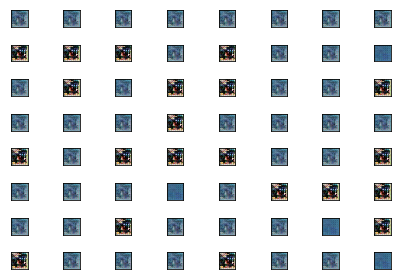

FID 249.46673153817386


In [0]:
from keras.models import load_model
from skimage import transform
from scipy.linalg import sqrtm
from keras.models import model_from_json
from keras.applications.inception_v3 import InceptionV3
from keras.backend import mean

import numpy as np


def resizeForInceptionV3(images1):
  #Declare empty list to store images
  imgList = list()
  
  #Resize each incoming image and add to list
  for image in images1:
      newImage = transform.resize(image,(299,299,3))
      imgList.append(newImage)
  return np.asarray(imgList)


def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(), np.cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(), np.cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if np.iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid  
  
generator = load_model('generatorModel.h5',custom_objects={'SelfAttention' : SelfAttention,
                                        'EmbeddingSN' : EmbeddingSN,
                                        'ConvSN2D' : ConvSN2D,
                                        'DenseSN' : DenseSN,
                                        'ConvSN2DTranspose' : ConvSN2DTranspose})
latent_dim = 100
inceptionModel = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
samples = 64
(xTrain, yTrain), (xTest, yTest) = cifar10.load_data()
label = yTrain[np.random.randint(0, xTrain.shape[0], samples)]

x_fake = generator.predict([np.random.normal(loc=0, scale=1, size=(samples, latent_dim)),label])
for k in range(samples):
    plt.subplot(8, 8, k + 1, xticks=[], yticks=[])
    plt.imshow(((x_fake[k] + 1)* 127).astype(np.uint8))

plt.tight_layout()
plt.show()
  
# Calculate FID
print('Calculating FID please wait..')
x_fake = generator.predict([np.random.normal(loc=0, scale=1, size=(samples, latent_dim)),label])
X_test = xTest[np.random.randint(0,xTest.shape[0], samples)]
images1 = resizeForInceptionV3(x_fake)
images2 = resizeForInceptionV3(X_test)
fid = calculate_fid(inceptionModel,images1,images2)
print('FID '+str(fid))


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Define Generator

In [0]:
'''BUILD GENERATOR  '''
'''Exactly like DCGAN with these changes'''
'''Consists of 4 Convolution2D Transpose layers with Spectral Normalisation starting from dimension 256 till 3
    One self attention layer at dimension 128. Also Embedding layer for conditional layer described below
and 1 Dense layer'''


def get_generator(latent_dim):
    n_nodes = 512 * 2 * 2
    in_x = Input(shape=(200,))
    x = Dense(n_nodes, input_shape=(200,))(in_x)
    x = Reshape((2, 2, 512))(x)
    #1
    x = ConvSN2DTranspose(256,kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    #2
    x = ConvSN2DTranspose(128,kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    #Self Attention
    x = SelfAttention(128)(x)
    
    #4
    x = ConvSN2DTranspose(64,kernel_size=3, strides= 2, padding='same')(x)
    x= (BatchNormalization())(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    # output layer
    x = ConvSN2DTranspose(3, (3,3), strides= 2, activation='tanh', padding='same')(x)
    model = Model(in_x,x)
    
    #Need two inputs for Conditional SAGAN, so creating labels
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,)) 
    
    #Using Embedding layer to create vector representation
    label_embedding = Flatten()(Embedding(10,latent_dim)(label))
    
    #Concatenating both inputs
    merge = k.layers.Concatenate()([noise,label_embedding])
    img = model(merge)
    return Model([noise,label],img)


### Calculate FID

In [0]:
def calculate_fid(act1, act2):
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(), np.cov(act2, rowvar=False)
    
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
        
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

### Define Discriminator

In [0]:
'''BUILD DISCRIMINATOR  '''
'''Exactly like DCGAN with these changes'''
'''Consists of 4 Convolution2D layers with Spectral Normalisation starting from dimension 64 till 512
    One self attention layer at dimension 128
and 1 Dense layer'''


def get_discriminator(inp_dim):
    in_x = Input(shape=(32,32,4))
    
    #1 
    x = ConvSN2D(64,kernel_size=5,strides=2,input_shape = (32,32,4))(in_x)
    x = LeakyReLU(0.2)(x)
    
    #2
    x = ConvSN2D(128,kernel_size=5,strides=2,padding='same')(x)
    x = LeakyReLU(0.2)(x)
    
    
    #Self Attention
    x = SelfAttention(128)(x)
    
    #3
    x = ConvSN2D(256,kernel_size=5,strides=2,padding='same')(x)
    x = LeakyReLU(0.2)(x)
    
    #4
    x = ConvSN2D(512,kernel_size=5,strides=2,padding='same')(x)
    x = LeakyReLU(0.2)(x)
    
    #Output
    x = ConvSN2D(1,kernel_size=5,strides=2,padding='same')(x)
    x = Flatten()(x)
    x = DenseSN(1, activation=None)(x)
    
    
    model = Model(in_x,x)
    image = Input(shape=(inp_dim),)
    label = Input(shape=(1,))
    label_embedding = (Embedding(10,32*32)(label))
    label_embedding = k.layers.Reshape((32,32,1))(label_embedding)
    merge = k.layers.Concatenate()([image,label_embedding])
    img = model(merge)
    return Model([image,label],img)


### Resize Image for inception model

In [0]:
def resizeForInceptionV3(images1):
  #Declare empty list to store images
  imgList = list()
  
  #Resize each incoming image and add to list
  for image in images1:
      newImage = transform.resize(image,(299,299,3))
      imgList.append(newImage)
  return np.asarray(imgList)

### Function to save model

In [0]:
#Save model architecture as Json and weights as h5 file

def save_model(model,JsonfileName,weightFileName):
  model_json = model.to_json()
  with open('/content/drive/My Drive/DLProject1/'+JsonfileName,'w') as json_file:
    json_file.write(model_json)
  model.save_weights('/content/drive/My Drive/DLProject1/'+weightFileName)


### Function to load model

In [0]:
# Load model by giving Json and h5 file

def load_model(JsonfileName,weightFileName):
  mJson = open(JsonfileName,'r')
  model_json = mJson.read()
  mJson.close()
  model = model_from_json(model_json,custom_objects={'SelfAttention' : SelfAttention,
                                          'EmbeddingSN' : EmbeddingSN,
                                          'ConvSN2D' : ConvSN2D,
                                          'DenseSN' : DenseSN,
                                          'ConvSN2DTranspose' : ConvSN2DTranspose})
  model.load_weights(weightFileName)
  return model

### Calculate FID

In [0]:
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


### Import Dataset and build discriminator and generator

In [0]:
#Download CIFAR10 Dataset
(xTrain, yTrain), (xTest, yTest) = cifar10.load_data()

#Specify input dimensions
inp_dim = xTrain[0].shape

#Normalize
xTrain = (xTrain-127.5)/127.5

#Build discriminator
discriminator = get_discriminator(inp_dim)

#Compile discriminator
discriminator.compile(Adam(lr=0.0004, beta_1=0.5), loss='hinge',
                      metrics=['binary_accuracy'])

#Build generator
generator = get_generator(100)

### Function for combined model

In [0]:
def define_gan(generator, discriminator,latent_dim):
    
    #Generate label
    label = Input(shape=(1,)) 
    
    #Noise generation
    z = Input(shape=(latent_dim,))  
    
    #Give noise, label input to generator to predict image
    img = generator([z,label])
    discriminator.trainable = False
    decision = discriminator([img,label])
    d_g = Model(inputs=[z,label], outputs=decision)
    d_g.compile(Adam(lr=0.0002, beta_1=0.5), loss='hinge',
                      metrics=['binary_accuracy'])
#     d_g.compile(RMSprop(lr=0.0003), loss='hinge',
#                 metrics=['binary_accuracy'])
    return d_g

In [0]:
'''Build combined model '''

latent_dim = 100
gan = define_gan(generator,discriminator,latent_dim)

In [0]:
tensorboard = TensorBoard(
  log_dir='/content/drive/My Drive/DLProject1/SALogs',
  histogram_freq=0,
  batch_size=64,
  write_graph=True,
  write_grads=True
)
tensorboard.set_model(gan)

### Train Model

call
call


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


****fid ****215.66481129959894


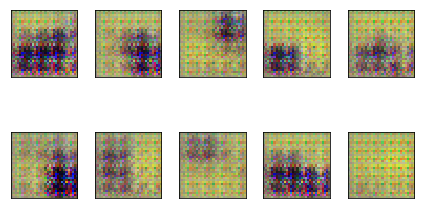

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


 Epoch = 0 dLoss =0.1853160262107849 gLoss = 2.0110245
****fid ****200.7176713599231


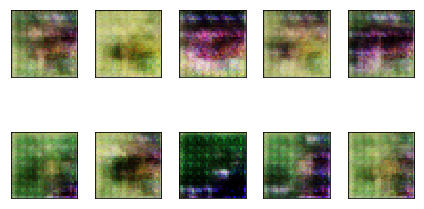

 Epoch = 1 dLoss =0.004424341022968292 gLoss = 0.0038122423
****fid ****203.0592862862199


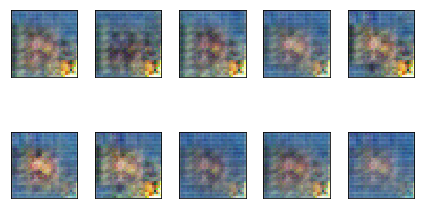

 Epoch = 2 dLoss =0.07333879172801971 gLoss = 0.7137404
****fid ****199.88594392502478


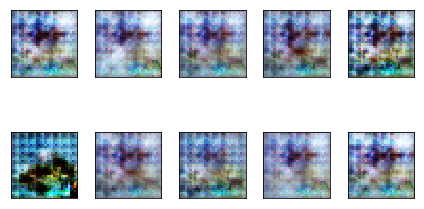

 Epoch = 3 dLoss =0.35667186975479126 gLoss = 2.3522625
****fid ****203.87342601710185


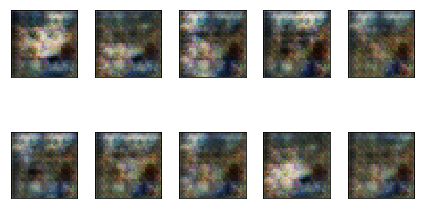

 Epoch = 4 dLoss =0.1055125892162323 gLoss = 1.8781288
****fid ****198.7836971015755


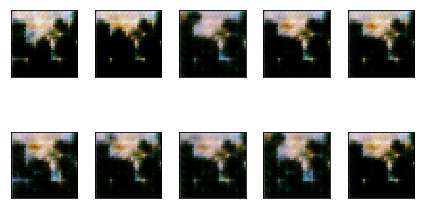

 Epoch = 5 dLoss =0.0 gLoss = 0.0
****fid ****200.50815059688054


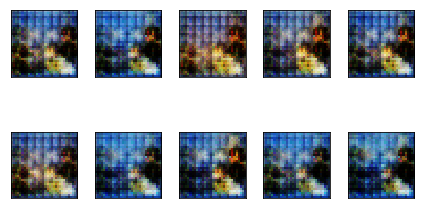

 Epoch = 6 dLoss =0.3093092143535614 gLoss = 2.2773218
****fid ****207.65071350299277


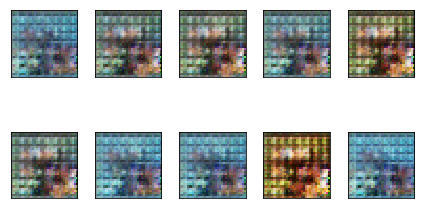

 Epoch = 7 dLoss =0.0037621338851749897 gLoss = 0.0
****fid ****189.42316140380748


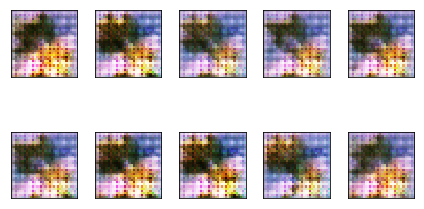

 Epoch = 8 dLoss =0.016189176589250565 gLoss = 0.022337776
****fid ****197.72618388256168


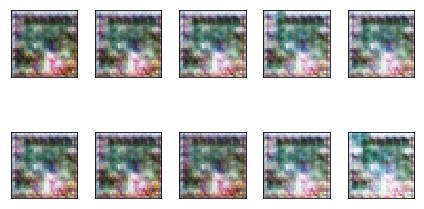

 Epoch = 9 dLoss =0.0 gLoss = 0.0012206463
****fid ****197.0335235147348


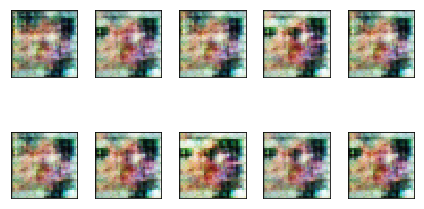

 Epoch = 10 dLoss =0.06280917674303055 gLoss = 0.51378834
****fid ****262.1432317376751


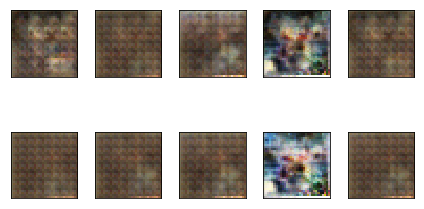

 Epoch = 11 dLoss =0.17840997874736786 gLoss = 1.9896069
****fid ****255.79691646530046


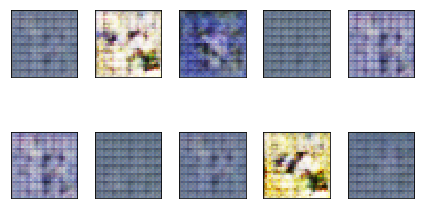

 Epoch = 12 dLoss =0.06570027768611908 gLoss = 0.87252915
****fid ****269.80229066180937


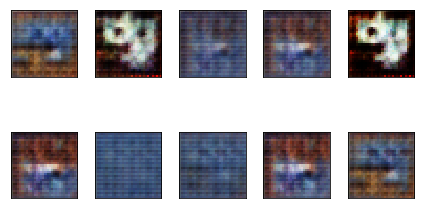

 Epoch = 13 dLoss =0.15081584453582764 gLoss = 1.3667717
****fid ****237.60096324854845


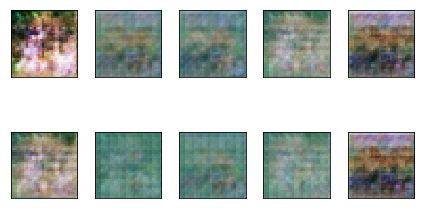

 Epoch = 14 dLoss =0.32627156376838684 gLoss = 1.851702
****fid ****232.21753425008302


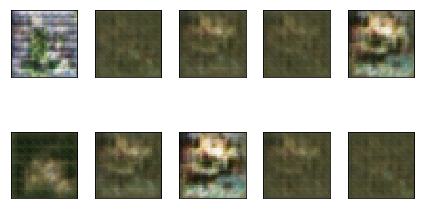

 Epoch = 15 dLoss =0.0930146872997284 gLoss = 2.2942781
****fid ****206.6611977109627


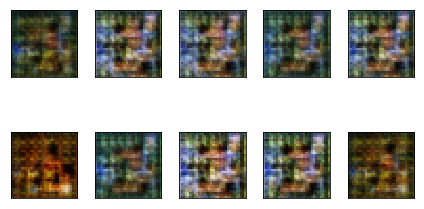

 Epoch = 16 dLoss =0.032621026039123535 gLoss = 0.0
****fid ****195.30866380560508


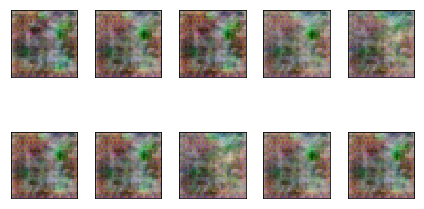

 Epoch = 17 dLoss =0.16709747910499573 gLoss = 2.354854
****fid ****211.6727319729675


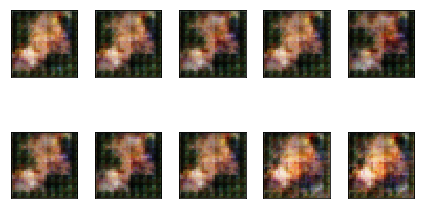

 Epoch = 18 dLoss =0.19845178723335266 gLoss = 2.5241961
****fid ****206.69527224533766


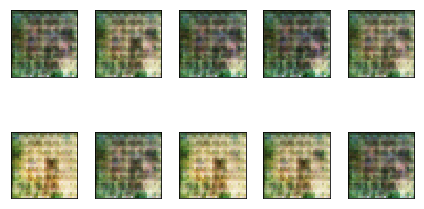

 Epoch = 19 dLoss =0.0 gLoss = 0.0
****fid ****198.8381750339668


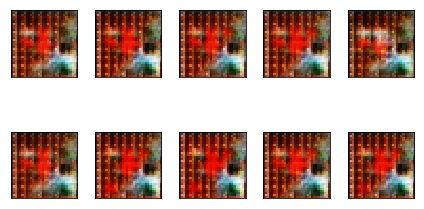

 Epoch = 20 dLoss =0.27489346265792847 gLoss = 3.681785
****fid ****209.86507121855757


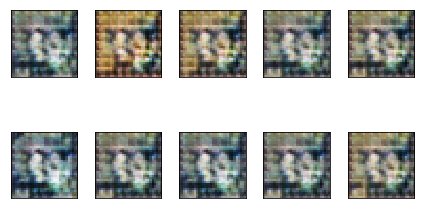

 Epoch = 21 dLoss =0.0 gLoss = 0.0
****fid ****205.8312558988398


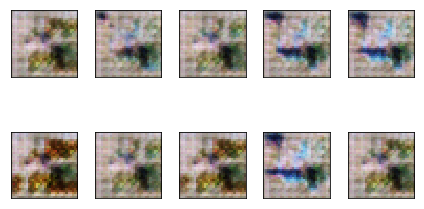

 Epoch = 22 dLoss =0.00020793825387954712 gLoss = 0.002916338
****fid ****201.10094529300022


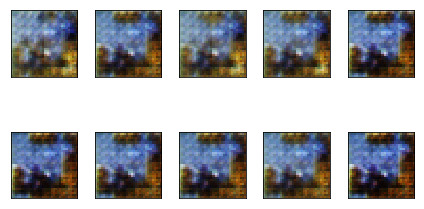

 Epoch = 23 dLoss =0.008044734597206116 gLoss = 0.3490871
****fid ****209.01992168669025


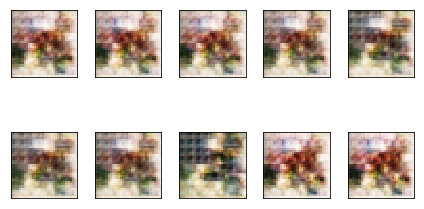

 Epoch = 24 dLoss =0.0 gLoss = 0.0
****fid ****216.27683746059438


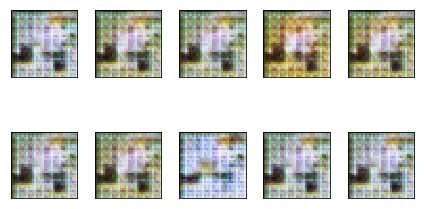

 Epoch = 25 dLoss =0.0 gLoss = 0.0
****fid ****197.53885090784388


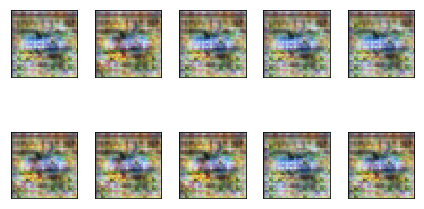

 Epoch = 26 dLoss =0.01320902444422245 gLoss = 0.0
****fid ****201.2168130288959


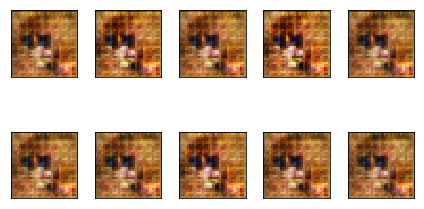

 Epoch = 27 dLoss =0.0 gLoss = 0.0
****fid ****193.80568187617428


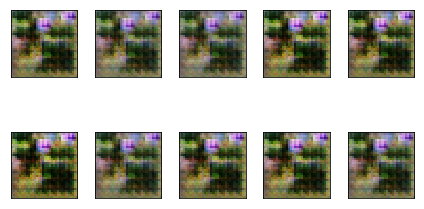

 Epoch = 28 dLoss =0.02388302981853485 gLoss = 0.0
****fid ****198.81003882204527


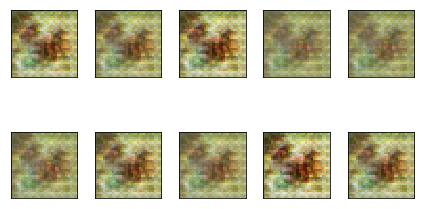

 Epoch = 29 dLoss =0.1648625284433365 gLoss = 0.34127462
****fid ****219.314764055266


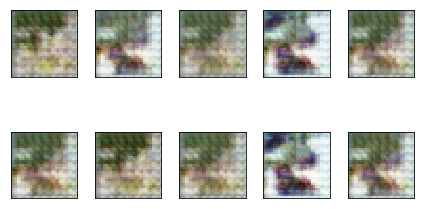

 Epoch = 30 dLoss =0.3835165202617645 gLoss = 0.93635577
****fid ****217.16443864413554


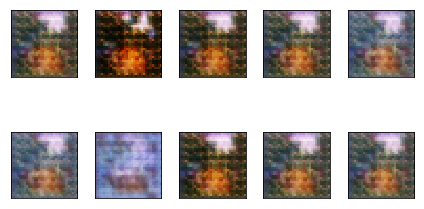

 Epoch = 31 dLoss =0.3033097982406616 gLoss = 2.4045038
****fid ****227.9762740461149


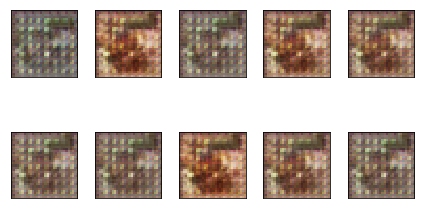

 Epoch = 32 dLoss =0.0 gLoss = 0.0
****fid ****203.52305853565642


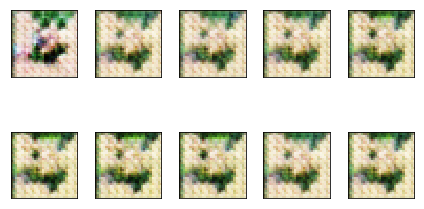

 Epoch = 33 dLoss =0.426837295293808 gLoss = 2.6563296
****fid ****246.30253884297935


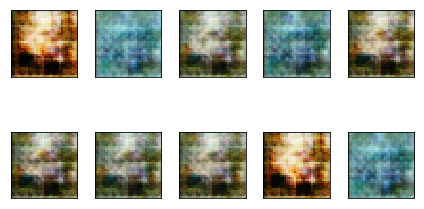

 Epoch = 34 dLoss =0.3294353485107422 gLoss = 0.045452755
****fid ****215.26221642369535


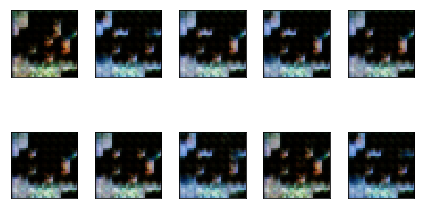

 Epoch = 35 dLoss =0.014391029253602028 gLoss = 0.0
****fid ****219.9430078499225


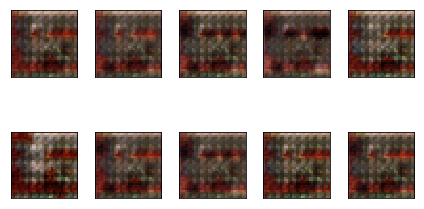

 Epoch = 36 dLoss =0.0033421358093619347 gLoss = 0.0
****fid ****201.51997041537533


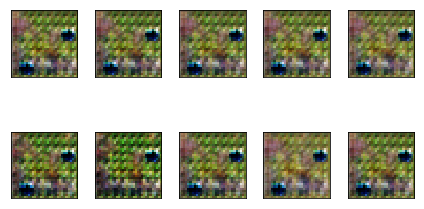

 Epoch = 37 dLoss =0.0 gLoss = 0.0
****fid ****196.5256583774449


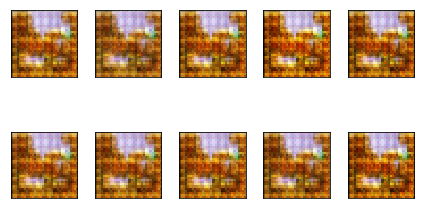

 Epoch = 38 dLoss =0.014346228912472725 gLoss = 0.049443442
****fid ****202.5330887488677


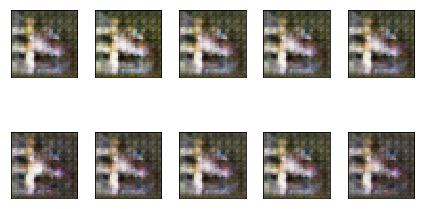

 Epoch = 39 dLoss =0.002568610478192568 gLoss = 0.0
****fid ****203.84546381210498


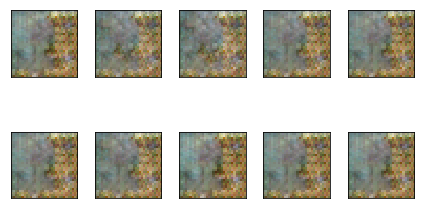

 Epoch = 40 dLoss =0.0 gLoss = 0.0
****fid ****195.62929460319765


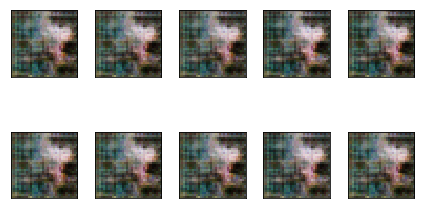

 Epoch = 41 dLoss =0.0 gLoss = 0.0
****fid ****195.7582884853532


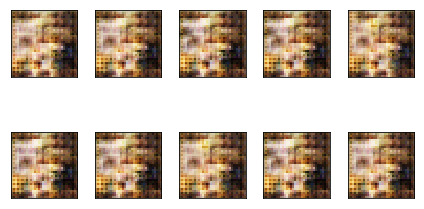

 Epoch = 42 dLoss =0.04212312400341034 gLoss = 0.0
****fid ****201.2290363901683


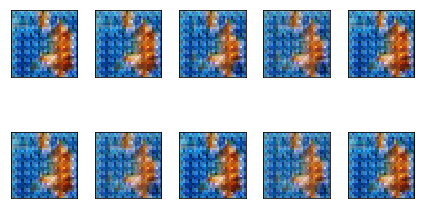

 Epoch = 43 dLoss =0.0 gLoss = 0.0
****fid ****198.43179338818783


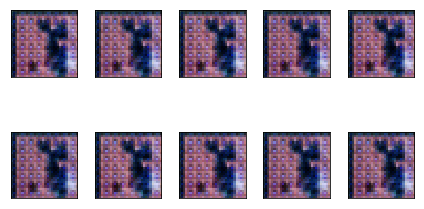

 Epoch = 44 dLoss =0.0018636411987245083 gLoss = 0.0
****fid ****199.79699970578392


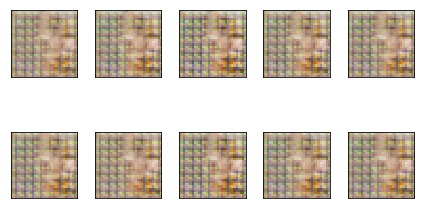

 Epoch = 45 dLoss =0.0 gLoss = 0.0
****fid ****198.18430442090798


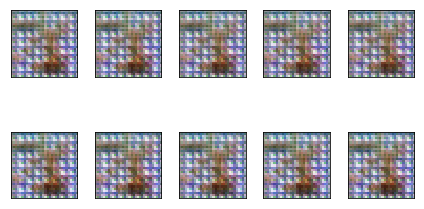

 Epoch = 46 dLoss =0.0 gLoss = 0.0
****fid ****196.07396957171207


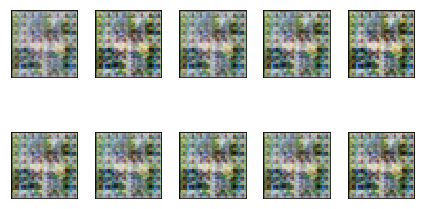

 Epoch = 47 dLoss =0.0 gLoss = 0.0
****fid ****196.12497599498914


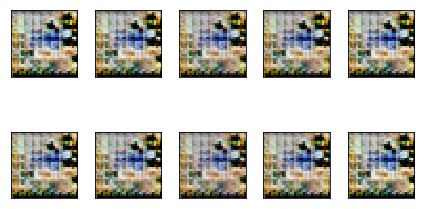

 Epoch = 48 dLoss =0.0 gLoss = 0.0
****fid ****197.03766920757886


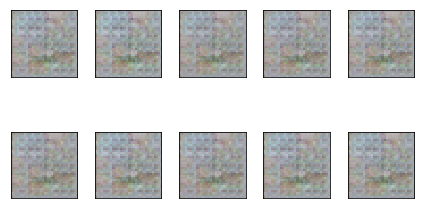

 Epoch = 49 dLoss =0.0005220095627009869 gLoss = 0.009581877
****fid ****195.58962712037805


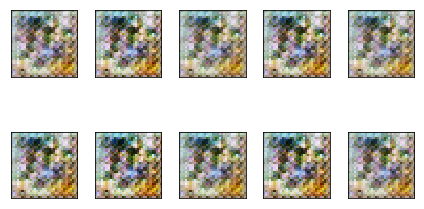

 Epoch = 50 dLoss =0.00202730530872941 gLoss = 0.0
****fid ****197.57783927203695


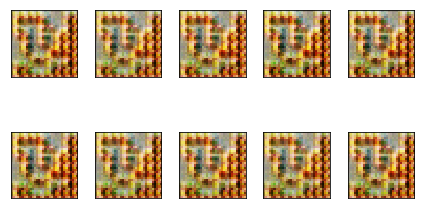

 Epoch = 51 dLoss =0.0005852235481142998 gLoss = 0.0
****fid ****195.80189736550713


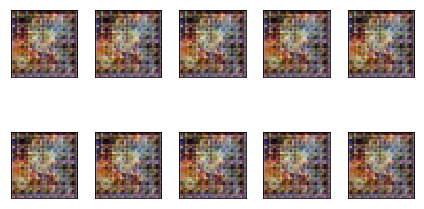

 Epoch = 52 dLoss =0.00398895051330328 gLoss = 0.0
****fid ****197.59292725816024


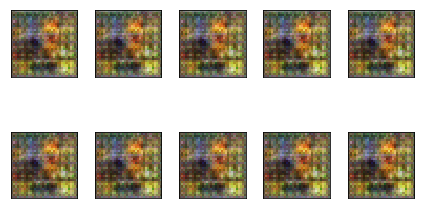

 Epoch = 53 dLoss =0.03980349004268646 gLoss = 0.0
****fid ****195.53835507454002


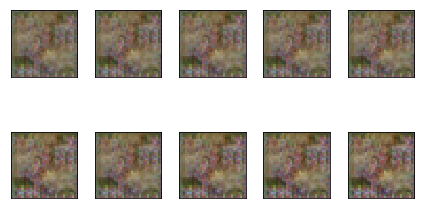

 Epoch = 54 dLoss =0.0 gLoss = 0.0
****fid ****198.24424959927705


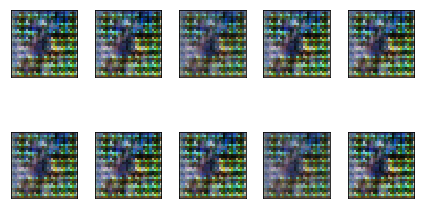

 Epoch = 55 dLoss =0.09707011282444 gLoss = 1.4175582
****fid ****233.59475251398095


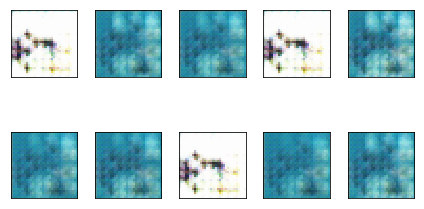

 Epoch = 56 dLoss =0.004711359739303589 gLoss = 0.0
****fid ****226.3613277702914


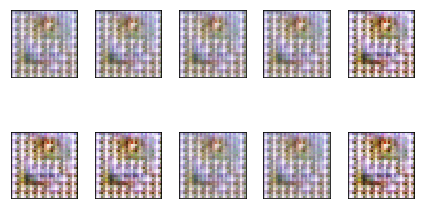

 Epoch = 57 dLoss =0.013242782093584538 gLoss = 0.008147849
****fid ****230.45576128519085


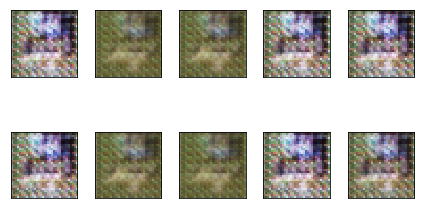

 Epoch = 58 dLoss =0.15213041007518768 gLoss = 2.2538385
****fid ****234.7596213472467


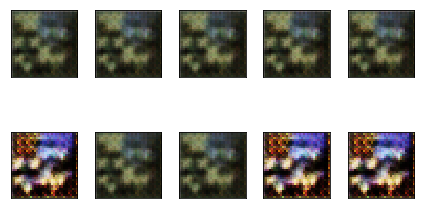

 Epoch = 59 dLoss =0.15094850957393646 gLoss = 0.34833962
****fid ****251.12304310573052


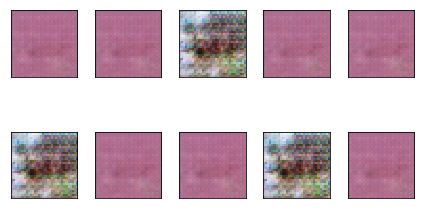

 Epoch = 60 dLoss =0.022900735959410667 gLoss = 0.84733975
****fid ****260.8565890563035


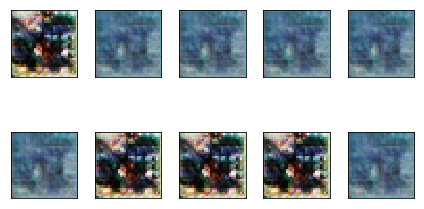

KeyboardInterrupt: ignored

In [0]:
#Train from scratch
batch_size = 64
smooth = 0.1
# real = np.ones((batch_size, 1), dtype=np.float32)
real = np.ones(shape=(batch_size, 1))
fake = np.ones((batch_size, 1))
fake = -fake
epoch = 100
fidL = []
dLoss = []
gLoss = []
fidCounter = 0
inceptionModel = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
gan  = define_gan(generator,discriminator,latent_dim=latent_dim)
for i in range(0,epoch):
  for j in range(len(xTrain) // batch_size):
    discriminator.trainable = False
    # Train on Real
    X_batch = xTrain[j*batch_size:(j+1)*batch_size]
    label = yTrain[np.random.randint(0, xTrain.shape[0], batch_size)]
    dLossReal = discriminator.train_on_batch([X_batch,label],real)
    #Fake
    z = np.random.normal(loc = 0,scale = 1,size = (batch_size,latent_dim))
    X_fake = generator.predict([z,label])
    dLossFake = discriminator.train_on_batch(x=[X_fake,label],y=fake)
    #Discriminator
    d_loss =  0.5 * (dLossReal[0] + dLossFake[0])
    discriminator.trainable = False
    g_loss = gan.train_on_batch(x=[z,label], y=real)
    if j % 1000 == 0:
      samples = 64
      x_fake = generator.predict([np.random.normal(loc=0, scale=1, size=(samples, latent_dim)),label])
      X_test = xTest[j*batch_size:(j+1)*batch_size]
      images1 = resizeForInceptionV3(x_fake)
      images2 = resizeForInceptionV3(X_test)
      fid = calculate_fid(inceptionModel,images1,images2)
      fidL.append(str(fid))
      tensorboard.on_epoch_end(j,{"fid":fid}) 
      print('****fid ****'+str(fid))
      
#     '''FOR 10k FID'''
#     fidCounter=fidCounter+1;
#     if fidCounter > 0:
#       fidCounter = 1
#       print('IN FID ')
#       resizedReal = []
#       resizedFake = []
#       samples = 10000
#       x_fake = generator.predict([np.random.normal(loc=0, scale=1, size=(samples, latent_dim)),label])
      
#       for size in range(len(xTest)//250):
#   #       for size in range(0,1):
#         images1 = resizeForInceptionV3(x_fake[size*250:(size+1)*250])
#         #resizedFake.append(images1)
#         images2 = resizeForInceptionV3(xTest[size*250:(size+1)*250])
#         act1 = inceptionModel.predict(images1)
#         act2 = inceptionModel.predict(images2)
#         for act in act1:
#           resizedReal.append(act)
#         for act in act2:
#           resizedFake.append(act)
#       fid = calculate_fid(np.asarray(resizedReal),np.asarray(resizedFake))
#       print('****fid ****'+str(fid))
#       fidL.append(str(fid))
#       tensorboard.on_epoch_end(epoch,{"fid":fid}) 
    
    if j % 1000 == 0:
        samples = 10
        x_fake = generator.predict([np.random.normal(loc=0, scale=1, size=(samples, latent_dim)),label])
          
        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(((x_fake[k] + 1)* 127).astype(np.uint8))

        plt.tight_layout()
        plt.show()
        tensorboard.on_epoch_end(j, {"D_real_loss":dLossReal[0] ,"D_fake_loss":dLossFake[0],"GAN_loss":g_loss[0]})
        
  #tensorboard.on_epoch_end(epoch, {"D_real_loss":dLossReal[0] ,"D_fake_loss":dLossFake[0],"GAN_loss":g_loss[0],"fid":fid}) 
  dLoss.append(str(d_loss))
  gLoss.append(str(g_loss[0]))
  print(' Epoch = '+str(i)+ ' dLoss ='+str(d_loss)+' gLoss = '+str(g_loss[0]))
  generator.save('/content/drive/My Drive/DLProject1/generatorModel.h5')
  discriminator.save('/content/drive/My Drive/DLProject1/discriminatorModel.h5')
  gan.save('/content/drive/My Drive/DLProject1/ganModel.h5')
  save_model(generator,'generatorSA.json','generatorSA.h5')
  save_model(discriminator,'discriminatorSA.json','discriminatorSA.h5')
  save_model(gan,'ganSA.json','ganSA.h5')
  

